# Rossmann Store Sales
### Forecast sales using store, promotion, and competitor data


Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
We are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column.

Data fields
- **Id** - An Id that represents a (Store, Date) duple within the test set
- **Store** - A unique Id for each store
- **Sales** - The turnover for any given day (this is what you are predicting)
- **Customers** - The number of customers on a given day
- **Open** - An indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - Indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday** - Indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType** - Differentiates between 4 different store models: a, b, c, d
- **Assortment** - Describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - Distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - Gives the approximate year and month of the time the nearest competitor was opened
- **Promo** - Indicates whether a store is running a promo on that day
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - Describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - Describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
# importing necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Loading dataset

In [2]:
# This is the data which contains store details
store_details = pd.read_csv("../data/raw/store.csv")
store_details.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [3]:
# Our Train data
train_data = pd.read_csv("../data/raw/train.csv")
train_data.head()

C:\Users\Ankit\AppData\Local\Temp\ipykernel_20356\1043789630.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("../data/raw/train.csv")


Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [4]:
# merged our train data and store details data based on store number to get complete info for each store
combined_data = pd.merge(train_data, store_details, on='Store')
combined_data.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      1          4  2015-07-30   5020        546     1      1            0   
2      1          3  2015-07-29   4782        523     1      1            0   
3      1          2  2015-07-28   5011        560     1      1            0   
4      1          1  2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         c          a               1270.0   
2              1         c          a               1270.0   
3              1         c          a               1270.0   
4              1         c          a               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval  
0              NaN              NaN           NaN  
1              NaN              NaN           NaN  
2              NaN              NaN           NaN  
3              NaN              NaN           NaN  
4              NaN              NaN           NaN

In [5]:
combined_data.shape

(1017209, 18)

## Exploring Dataset

In [6]:
# missing values in the dataset
print("Total size of dataset: ", len(combined_data))
print(combined_data.isnull().sum())

Total size of dataset:  1017209
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64


In [7]:
# unique values in dataset
columns = list(combined_data.columns)
columns.remove('Date')
columns.remove('CompetitionDistance')
for col in columns:
    print(f'{col:<25} {combined_data[col].unique()}')

Store                     [   1    2    3 ... 1113 1114 1115]
DayOfWeek                 [5 4 3 2 1 7 6]
Sales                     [ 5263  5020  4782 ... 20362 18841 21237]
Customers                 [ 555  546  523 ... 3727 4022 4106]
Open                      [1 0]
Promo                     [1 0]
StateHoliday              ['0' 'a' 'b' 'c' 0]
SchoolHoliday             [1 0]
StoreType                 ['c' 'a' 'd' 'b']
Assortment                ['a' 'c' 'b']
CompetitionOpenSinceMonth [ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.]
CompetitionOpenSinceYear  [2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]
Promo2                    [0 1]
Promo2SinceWeek           [nan 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.]
Promo2SinceYear           [  nan 2010. 2011. 2012. 2009. 2014. 2015. 2013.]
PromoInterval             [nan 'Jan,Apr,Jul,Oct' '

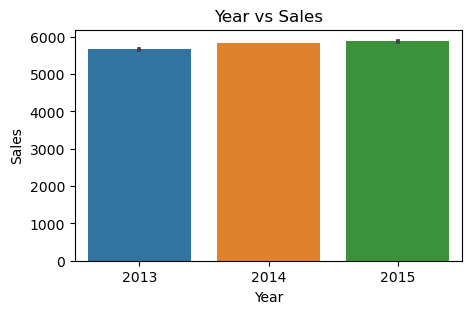

In [8]:
# extracting year and month from Date 
combined_data['Year']  = combined_data['Date'].apply(lambda x: int(str(x)[:4]))
combined_data['Month'] = combined_data['Date'].apply(lambda x: int(str(x)[5:7]))

# Sales with respect to year 
plt.figure(figsize=(5,3))
sns.barplot(x='Year', y='Sales', data=combined_data).set(title='Year vs Sales')
plt.show()

**Observation**: Average sales have been increasing year to year

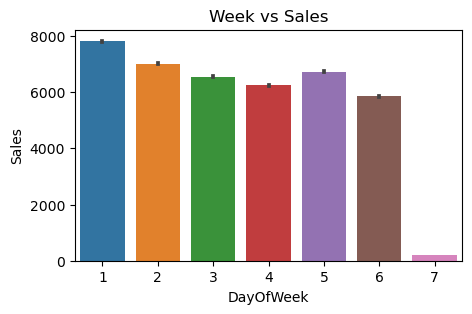

In [9]:
# Sales with respect to week
plt.figure(figsize=(5,3))
sns.barplot(x='DayOfWeek', y='Sales', data=combined_data).set(title='Week vs Sales')
plt.show()

**Observation**: Avg. Sales on 1 (Monday), 2 (Tuesday), and 5 (Friday) are the highest

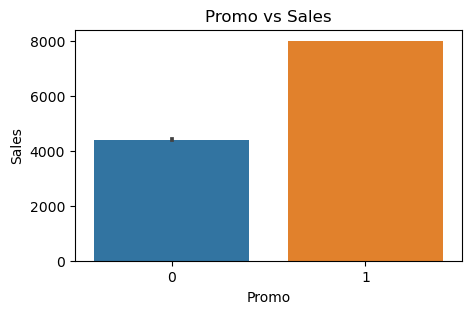

In [10]:
# Sales with respect to Promo
plt.figure(figsize=(5,3))
sns.barplot(x='Promo', y='Sales', data=combined_data).set(title='Promo vs Sales')
plt.show()

**Observation**: Sales are higher when the store is running a promo

C:\Users\Ankit\AppData\Local\Temp\ipykernel_20356\1339686731.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data["StateHoliday"].loc[combined_data["StateHoliday"] == 0] = "0"


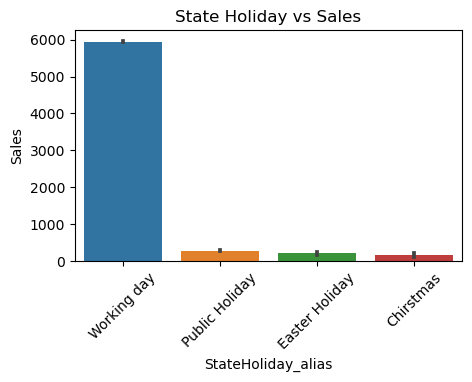

In [11]:
# StateHoliday column has values 0 & "0", So, we need to change values with 0 to "0"
combined_data["StateHoliday"].loc[combined_data["StateHoliday"] == 0] = "0"

# Sales with respect to State Holiday
aliases = {'a': 'Public Holiday',
           'b': 'Easter Holiday',
           'c': 'Chirstmas',
           '0': 'Working day'}

combined_data['StateHoliday_alias'] = combined_data["StateHoliday"].map(aliases)
plt.figure(figsize=(5,3))
sns.barplot(x='StateHoliday_alias', y='Sales', data=combined_data).set(title='State Holiday vs Sales')
plt.xticks(rotation=45)
plt.show()

**Observation**: Most stores are closed on State Holidays; thus, sales are low then.

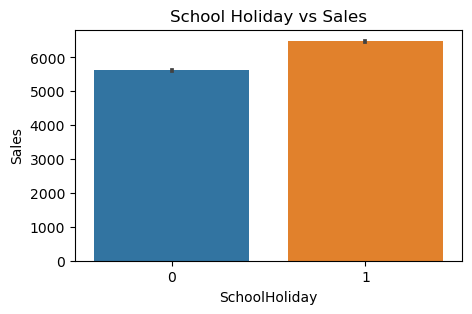

In [12]:
# Sales with respect to School Holiday
plt.figure(figsize=(5,3))
sns.barplot(x='SchoolHoliday', y='Sales', data=combined_data).set(title='School Holiday vs Sales')
plt.show()

**Observation**: On School Holidays, sales are high.

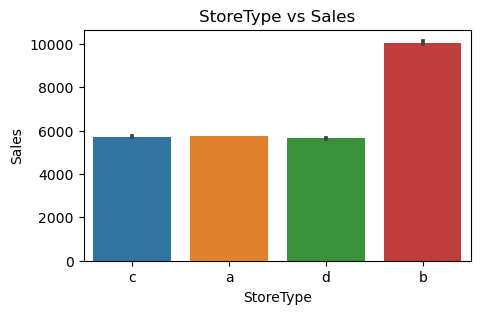

In [13]:
# Sales with respect to StoreType
plt.figure(figsize=(5,3))
sns.barplot(x='StoreType', y='Sales', data=combined_data).set(title='StoreType vs Sales')
plt.show()

**Observation**: a,b,c,d are store models where b type stores have the highest sales 

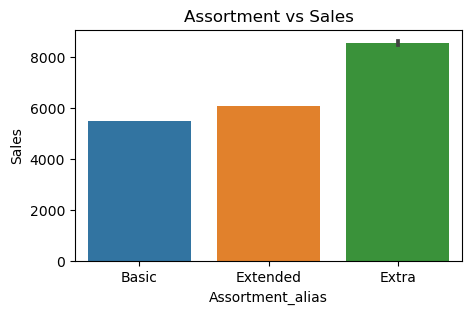

In [14]:
# Sales with respect to Assortment
aliases = {'a': 'Basic',
           'b': 'Extra',
           'c': 'Extended'}

combined_data['Assortment_alias'] = combined_data['Assortment'].map(aliases)

plt.figure(figsize=(5,3))
sns.barplot(x='Assortment_alias', y='Sales', data=combined_data).set(title='Assortment vs Sales')
plt.show()

**Observation**: Assortment Type 'Extra' have the highest sales

## Filling Missing Values and Removing Outliers

Few columns in store_details table have high number of missing values, so we need to fill them with appropriate method for better result

In [15]:
store_details.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

### Filling Missing Values
##### Approach
1: The null values in Column Promo2SinceWeek, Promo2SinceYear, PromoInterval is due to Promo2 is 0 (non-participating) for those stores. So we would fill all the null values in these columns with 0.

2: Since Competition Distance for 3 stores isn't given. We can keep it null or fill it with mean of the distance given for all other stores. A comparision can be studied.

3: Features CompetitionOpenSinceMonth and CompetitionOpenSinceYear with null values can be kept null or they can be filled using the most occuring month and year respectively. Again, a comparision can be studied.

In [16]:
train_data.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [17]:
# Filling Promo2SinceWeek, Promo2SinceYear, PromoInterval with 0
store_details.update(store_details[['Promo2SinceWeek','Promo2SinceYear','PromoInterval']].fillna(0))

In [18]:
# Filling CompetitionDistance with mean distance
mean_competition_distance = store_details['CompetitionDistance'].mean()
store_details['CompetitionDistance_raw'] = store_details['CompetitionDistance'].copy(deep=True)
store_details['CompetitionDistance'].fillna(mean_competition_distance, inplace=True)

In [19]:
# Filling CompetitionOpenSinceMonth, CompetitionOpenSinceYear with most occuring month and year respectively
mode_competition_open_month = store_details['CompetitionOpenSinceMonth'].mode()[0]
mode_competition_open_year = store_details['CompetitionOpenSinceYear'].mode()[0]

store_details['CompetitionOpenSinceMonth_raw'] = store_details['CompetitionOpenSinceMonth'].copy(deep=True)
store_details['CompetitionOpenSinceYear_raw'] = store_details['CompetitionOpenSinceYear'].copy(deep=True)

store_details['CompetitionOpenSinceMonth'].fillna(mode_competition_open_month,inplace=True)
store_details['CompetitionOpenSinceYear'].fillna(mode_competition_open_year,inplace=True)

In [20]:
store_details.isnull().sum()

Store                              0
StoreType                          0
Assortment                         0
CompetitionDistance                0
CompetitionOpenSinceMonth          0
CompetitionOpenSinceYear           0
Promo2                             0
Promo2SinceWeek                    0
Promo2SinceYear                    0
PromoInterval                      0
CompetitionDistance_raw            3
CompetitionOpenSinceMonth_raw    354
CompetitionOpenSinceYear_raw     354
dtype: int64

* All missing values have been filled

In [21]:
# merging the data again
combined_data = pd.merge(train_data, store_details, on='Store')
combined_data.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      1          4  2015-07-30   5020        546     1      1            0   
2      1          3  2015-07-29   4782        523     1      1            0   
3      1          2  2015-07-28   5011        560     1      1            0   
4      1          1  2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType  ... CompetitionDistance  \
0              1         c  ...              1270.0   
1              1         c  ...              1270.0   
2              1         c  ...              1270.0   
3              1         c  ...              1270.0   
4              1         c  ...              1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear  PromoInterval CompetitionDistance_raw  \
0              0.0              0.0              0                  1270.0   
1              0.0              0.0              0                  1270.0   
2              0.0              0.0              0                  1270.0   
3              0.0              0.0              0                  1270.0   
4              0.0              0.0              0                  1270.0   

   CompetitionOpenSinceMonth_raw  CompetitionOpenSinceYear_raw  
0                            9.0                        2008.0  
1                            9.0                        2008.0  
2                            9.0                        2008.0  
3                            9.0                        2008.0  
4                            9.0                        2008.0  

[5 rows x 21 columns]

In [22]:
combined_data.isnull().sum()

Store                                 0
DayOfWeek                             0
Date                                  0
Sales                                 0
Customers                             0
Open                                  0
Promo                                 0
StateHoliday                          0
SchoolHoliday                         0
StoreType                             0
Assortment                            0
CompetitionDistance                   0
CompetitionOpenSinceMonth             0
CompetitionOpenSinceYear              0
Promo2                                0
Promo2SinceWeek                       0
Promo2SinceYear                       0
PromoInterval                         0
CompetitionDistance_raw            2642
CompetitionOpenSinceMonth_raw    323348
CompetitionOpenSinceYear_raw     323348
dtype: int64

<Axes: title={'center': 'Sales vs CompetitionDistance'}, xlabel='CompetitionDistance', ylabel='Sales'>

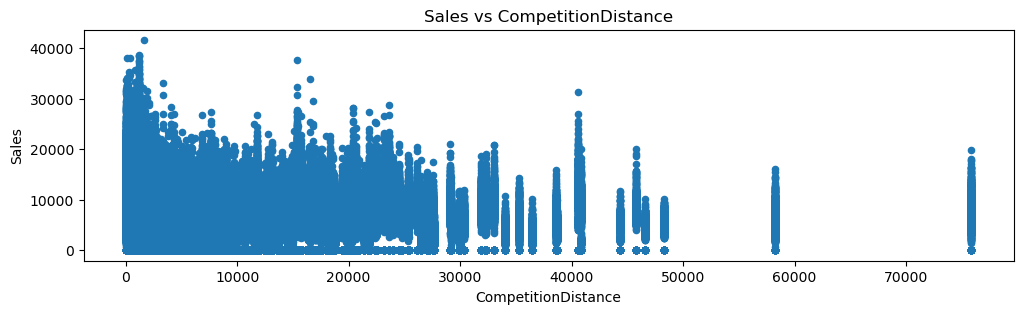

In [25]:
combined_data.plot(kind='scatter',x='CompetitionDistance',y='Sales',figsize=(12,3),title="Sales vs CompetitionDistance")

* CompetitionDistance is the distance in meters to the nearest competitor store, the more nearer the two stores are the more sales can be seen

### Finding Outliers

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


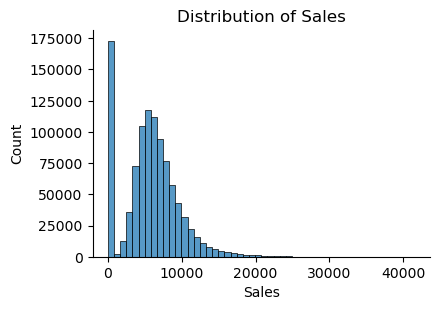

In [32]:
# checking distribution of sales 
sns.displot(combined_data, x="Sales",bins=50, height=3, aspect=1.5).set(title='Distribution of Sales')

**Observation**: Sales greater than 30k can be considered outliers

In [34]:
# Looking for outliers
sales_zero = combined_data.loc[combined_data['Sales'] == 0] 
sales_greater_than_30k = combined_data.loc[combined_data['Sales'] > 30000]

print("Length of actual dataset:", len(combined_data))
print("Length of data where sales is 0:", len(sales_zero),
      " which is", len(sales_zero)/len(combined_data)*100, "% of the whole data", )

print("Length of data which is greater than 30:", len(sales_greater_than_30k),
      "which is ", len(sales_greater_than_30k)/len(combined_data)*100, "% of the whole data")

Length of actual dataset: 1017209
Length of data where sales is 0: 172871  which is 16.994639253093514 % of the whole data
Length of data which is greater than 30: 153 which is  0.015041156733768577 % of the whole data


* Droping sales which are greater than 30k as they are very less in the dataset and are probably outliers

In [35]:
combined_data.drop(combined_data.loc[combined_data['Sales'] > 30000].index,inplace=True)
combined_data.shape

(1017056, 21)

## Further EDA - exploring exceptional cases
Looking for a scenerio where the Stores are open and yet there is no sales on that day

In [36]:
# no sales when Stores were Open
no_holiday_zero_sales = combined_data.loc[(combined_data['Sales'] == 0) & (combined_data['Open'] == 1) & 
                                          (combined_data['StateHoliday'] == 0) & (combined_data['SchoolHoliday'] == 0)]

print("Size of the data where sales were zero even when stores were open: ",len(no_holiday_zero_sales))
no_holiday_zero_sales.head()

Size of the data where sales were zero even when stores were open:  12


Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
22589      25          4  2014-02-13      0          0     1      0   
22590      25          3  2014-02-12      0          0     1      0   
25212      28          4  2014-09-04      0          0     1      1   
205303    227          4  2014-09-11      0          0     1      0   
297110    327          3  2014-03-12      0          0     1      0   

       StateHoliday  SchoolHoliday StoreType  ... CompetitionDistance  \
22589             0              0         c  ...               430.0   
22590             0              0         c  ...               430.0   
25212             0              0         a  ...              1200.0   
205303            0              0         a  ...              2370.0   
297110            0              0         c  ...              1390.0   

        CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
22589                         4.0                    2003.0       0   
22590                         4.0                    2003.0       0   
25212                        10.0                    2014.0       1   
205303                        9.0                    2013.0       0   
297110                       12.0                    2004.0       0   

        Promo2SinceWeek  Promo2SinceYear     PromoInterval  \
22589               0.0              0.0                 0   
22590               0.0              0.0                 0   
25212               6.0           2015.0  Mar,Jun,Sept,Dec   
205303              0.0              0.0                 0   
297110              0.0              0.0                 0   

       CompetitionDistance_raw  CompetitionOpenSinceMonth_raw  \
22589                    430.0                            4.0   
22590                    430.0                            4.0   
25212                   1200.0                           10.0   
205303                  2370.0                            NaN   
297110                  1390.0                           12.0   

        CompetitionOpenSinceYear_raw  
22589                         2003.0  
22590                         2003.0  
25212                         2014.0  
205303                           NaN  
297110                        2004.0  

[5 rows x 21 columns]

* Removing these data points too as they are an exceptional case

In [38]:
combined_data.drop(no_holiday_zero_sales.index,inplace=True)
combined_data.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      1          4  2015-07-30   5020        546     1      1            0   
2      1          3  2015-07-29   4782        523     1      1            0   
3      1          2  2015-07-28   5011        560     1      1            0   
4      1          1  2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType  ... CompetitionDistance  \
0              1         c  ...              1270.0   
1              1         c  ...              1270.0   
2              1         c  ...              1270.0   
3              1         c  ...              1270.0   
4              1         c  ...              1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear  PromoInterval CompetitionDistance_raw  \
0              0.0              0.0              0                  1270.0   
1              0.0              0.0              0                  1270.0   
2              0.0              0.0              0                  1270.0   
3              0.0              0.0              0                  1270.0   
4              0.0              0.0              0                  1270.0   

   CompetitionOpenSinceMonth_raw  CompetitionOpenSinceYear_raw  
0                            9.0                        2008.0  
1                            9.0                        2008.0  
2                            9.0                        2008.0  
3                            9.0                        2008.0  
4                            9.0                        2008.0  

[5 rows x 21 columns]

## Converting Categorical Variable to Numeric

In [40]:
# extracting year and month from Date 
combined_data['Year']  = combined_data['Date'].apply(lambda x: int(str(x)[:4]))
combined_data['Month'] = combined_data['Date'].apply(lambda x: int(str(x)[5:7]))
combined_data.drop(['Date'],axis=1,inplace=True)

In [41]:
combined_data.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0      1          5   5263        555     1      1            0   
1      1          4   5020        546     1      1            0   
2      1          3   4782        523     1      1            0   
3      1          2   5011        560     1      1            0   
4      1          1   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  ...  CompetitionOpenSinceYear  Promo2  \
0              1         c          a  ...                    2008.0       0   
1              1         c          a  ...                    2008.0       0   
2              1         c          a  ...                    2008.0       0   
3              1         c          a  ...                    2008.0       0   
4              1         c          a  ...                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear  PromoInterval  CompetitionDistance_raw  \
0              0.0              0.0              0                   1270.0   
1              0.0              0.0              0                   1270.0   
2              0.0              0.0              0                   1270.0   
3              0.0              0.0              0                   1270.0   
4              0.0              0.0              0                   1270.0   

  CompetitionOpenSinceMonth_raw  CompetitionOpenSinceYear_raw  Year  Month  
0                           9.0                        2008.0  2015      7  
1                           9.0                        2008.0  2015      7  
2                           9.0                        2008.0  2015      7  
3                           9.0                        2008.0  2015      7  
4                           9.0                        2008.0  2015      7  

[5 rows x 22 columns]

In [42]:
# encoding all categorical varibale to numeric values
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()

combined_data['StoreType']= label_encoder.fit_transform(combined_data['StoreType'])
combined_data['Assortment']= label_encoder.fit_transform(combined_data['Assortment']) 

# for promo interval
combined_data["PromoInterval"].loc[combined_data["PromoInterval"] == "Jan,Apr,Jul,Oct"] = 1
combined_data["PromoInterval"].loc[combined_data["PromoInterval"] == "Feb,May,Aug,Nov"] = 2
combined_data["PromoInterval"].loc[combined_data["PromoInterval"] == "Mar,Jun,Sept,Dec"] = 3
'''
new_promo_interval = []
for i in range(len(combined_data)):
    if combined_data['PromoInterval'][i] == 'Jan,Apr,Jul,Oct':
        new_promo_interval.append(1)
    elif combined_data['PromoInterval'][i] == 'Feb,May,Aug,Nov':
        new_promo_interval.append(2)
    elif combined_data['PromoInterval'][i] == 'Mar,Jun,Sept,Dec':
        new_promo_interval.append(3)
    else:
        new_promo_interval.append(0)
        
combined_data['PromoInterval'] = new_promo_interval        
'''

# for State Holiday
combined_data["StateHoliday"].loc[combined_data["StateHoliday"] == "a"] = 1
combined_data["StateHoliday"].loc[combined_data["StateHoliday"] == "b"] = 2
combined_data["StateHoliday"].loc[combined_data["StateHoliday"] == "c"] = 3

'''
state_holiday_list = []
for i in range(len(combined_data)):
    if combined_data['StateHoliday'][i] == 'a':
        state_holiday_list.append(1)
    elif combined_data['StateHoliday'][i] == 'b':
        state_holiday_list.append(2)
    elif combined_data['StateHoliday'][i] == 'c':
        state_holiday_list.append(3)
    else:
        state_holiday_list.append(0)


combined_data['StateHoliday'] = state_holiday_list
'''
combined_data.head()

C:\Users\Ankit\AppData\Local\Temp\ipykernel_20356\1650205592.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data["PromoInterval"].loc[combined_data["PromoInterval"] == "Jan,Apr,Jul,Oct"] = 1
C:\Users\Ankit\AppData\Local\Temp\ipykernel_20356\1650205592.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data["PromoInterval"].loc[combined_data["PromoInterval"] == "Feb,May,Aug,Nov"] = 2
C:\Users\Ankit\AppData\Local\Temp\ipykernel_20356\1650205592.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0      1          5   5263        555     1      1            0   
1      1          4   5020        546     1      1            0   
2      1          3   4782        523     1      1            0   
3      1          2   5011        560     1      1            0   
4      1          1   6102        612     1      1            0   

   SchoolHoliday  StoreType  Assortment  ...  CompetitionOpenSinceYear  \
0              1          2           0  ...                    2008.0   
1              1          2           0  ...                    2008.0   
2              1          2           0  ...                    2008.0   
3              1          2           0  ...                    2008.0   
4              1          2           0  ...                    2008.0   

   Promo2  Promo2SinceWeek  Promo2SinceYear  PromoInterval  \
0       0              0.0              0.0              0   
1       0              0.0              0.0              0   
2       0              0.0              0.0              0   
3       0              0.0              0.0              0   
4       0              0.0              0.0              0   

   CompetitionDistance_raw CompetitionOpenSinceMonth_raw  \
0                   1270.0                           9.0   
1                   1270.0                           9.0   
2                   1270.0                           9.0   
3                   1270.0                           9.0   
4                   1270.0                           9.0   

   CompetitionOpenSinceYear_raw  Year  Month  
0                        2008.0  2015      7  
1                        2008.0  2015      7  
2                        2008.0  2015      7  
3                        2008.0  2015      7  
4                        2008.0  2015      7  

[5 rows x 22 columns]

In [43]:
combined_data['StateHoliday'] = pd.to_numeric(combined_data['StateHoliday'])
combined_data['PromoInterval'] = pd.to_numeric(combined_data['PromoInterval'])

<Figure size 2000x1000 with 0 Axes>

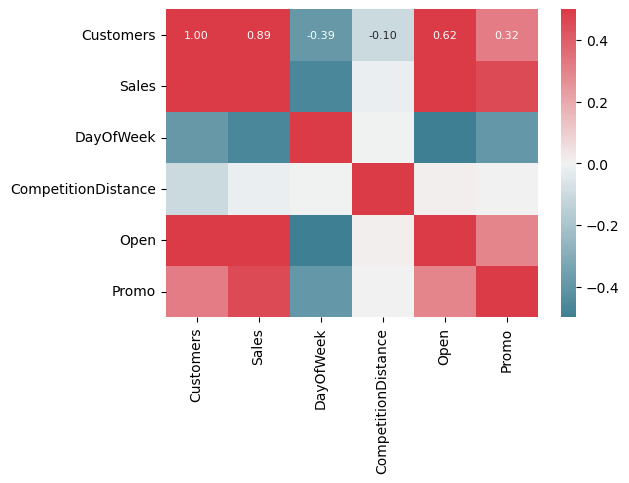

In [72]:
plt.figure(figsize=(20,10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
combined_data_corr = combined_data[['Customers', 'Sales', 'DayOfWeek', 'CompetitionDistance', 'Open', 'Promo']]

plt.figure(figsize=(6,4))
sns.heatmap(combined_data_corr.corr(),cmap=cmap, annot=True, fmt='.2f', vmin=-0.5, vmax=0.5, annot_kws={'size':8})
plt.show()

**Observations**: Correlation map shows sales is highly correlated with Customers, Open and Promo

## Implementing Models

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math  

In [84]:
combined_data_open = combined_data[combined_data['Open'] == 1]
combined_data_closed = combined_data[combined_data['Open'] == 0]

x_open = combined_data_open.drop(['Sales','Customers', 'Open', 'CompetitionDistance_raw', 'CompetitionOpenSinceMonth_raw', 'CompetitionOpenSinceYear_raw'],axis=1)
y_open = combined_data_open['Sales']
x_train, x_test_open, y_train, y_test_open = train_test_split(x_open,y_open,test_size=0.20)

In [85]:
epsilon = 1e-10

In [86]:
x_train.columns

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month'],
      dtype='object')

## Linear Regression

r2_score:  0.7748816250324797
Mean absolute error: 996.88
Root mean squared error:  1937.761216928402


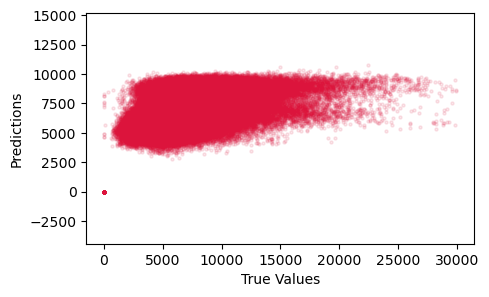

In [104]:
from sklearn import linear_model

lr_model = linear_model.LinearRegression() # making regression model
lr_model.fit(x_train, y_train) 
y_pred_open = lr_model.predict(x_test_open)
y_pred = np.append(y_pred_open, np.zeros(combined_data_closed.shape[0]))
y_test = np.append(y_test_open, np.zeros(combined_data_closed.shape[0]))

print("r2_score: ",r2_score(y_test,y_pred))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,y_pred))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

plt.figure(figsize=(5,3))
plt.scatter(y_test,y_pred, c='crimson', s = 5, alpha=0.1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.show()

## Decision Tree Regressor

r2_score:  0.9510066070765079
Mean absolute error: 421.70
Root mean squared error:  903.9898312667734


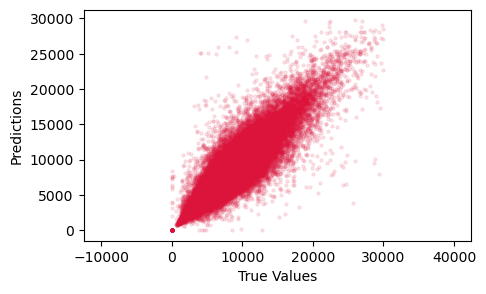

In [99]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor()
dt_model.fit(x_train, y_train) 
y_pred_open = dt_model.predict(x_test_open)
y_pred = np.append(y_pred_open, np.zeros(combined_data_closed.shape[0]))
y_test = np.append(y_test_open, np.zeros(combined_data_closed.shape[0]))

print("r2_score: ",r2_score(y_test,y_pred))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,y_pred))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))


plt.figure(figsize=(5,3))
plt.scatter(y_test,y_pred, c='crimson', s = 5, alpha=0.1)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.show()

## Random Forest Regressor

r2_score:  0.9650002366016175
Mean absolute error: 357.51
Root mean squared error:  764.0597837439735


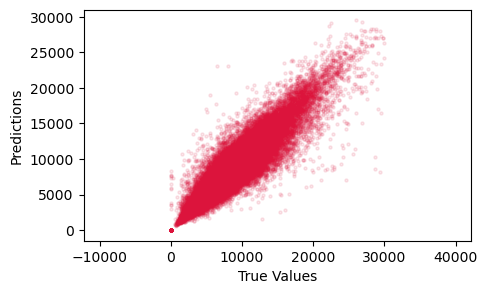

In [105]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train) 
y_pred_open = rf_model.predict(x_test_open)
y_pred = np.append(y_pred_open, np.zeros(combined_data_closed.shape[0]))
y_test = np.append(y_test_open, np.zeros(combined_data_closed.shape[0]))

print("r2_score: ",r2_score(y_test,y_pred))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,y_pred))
print("Root mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))



plt.figure(figsize=(5,3))
plt.scatter(y_test,y_pred, c='crimson', s = 5, alpha=0.1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.show()

**Obervation**: Random Forest Regressor had the lowest error as compared to other models.

## Feature Importance Analysis

In [106]:
# getting weights of all the features used in the data
feature_importance = rf_model.feature_importances_
feature_importance

array([0.17723719, 0.08153539, 0.14003978, 0.00122815, 0.01255116,
       0.03626554, 0.03131564, 0.20946227, 0.06854235, 0.0761422 ,
       0.00327534, 0.02979953, 0.03330968, 0.01249607, 0.02390275,
       0.06289696])

In [111]:
# making a dataframe
feature_importance_df = pd.DataFrame({"Features":list(x_train.columns),
                                     "Values":feature_importance.round(5)})
feature_importance_df.sort_values(by=["Values"], inplace=True, ascending=False)
feature_importance_df

Features   Values
7         CompetitionDistance  0.20946
0                       Store  0.17724
2                       Promo  0.14004
1                   DayOfWeek  0.08154
9    CompetitionOpenSinceYear  0.07614
8   CompetitionOpenSinceMonth  0.06854
15                      Month  0.06290
5                   StoreType  0.03627
12            Promo2SinceYear  0.03331
6                  Assortment  0.03132
11            Promo2SinceWeek  0.02980
14                       Year  0.02390
4               SchoolHoliday  0.01255
13              PromoInterval  0.01250
10                     Promo2  0.00328
3                StateHoliday  0.00123

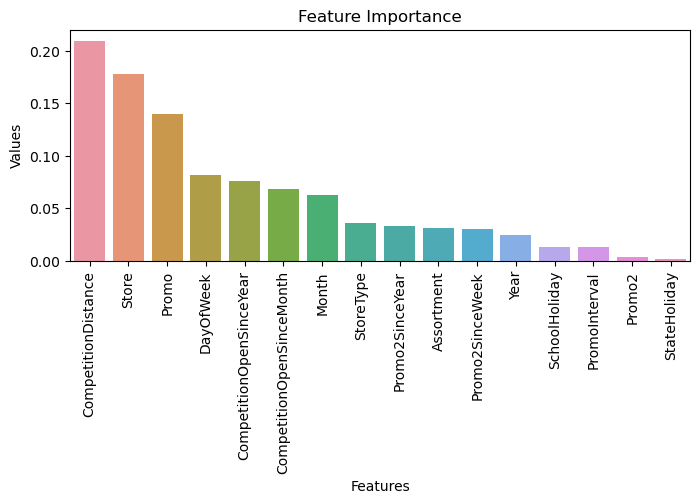

In [112]:
# Feature Importance
plt.figure(figsize=(8,3))

sns.barplot(x=feature_importance_df['Features'], y=feature_importance_df['Values'],
            data = feature_importance_df ).set(title='Feature Importance')

plt.xticks(rotation=90)
plt.show()

## To do:
Predict the sales